In [308]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/Datasets/'
    model_Path = '/home/bilz/models/'

datasetNameSeen = 'DeepIOD_Dataset.csv'
datasetNameUnseen = 'Omer_Dataset.csv'

dataset_Path_Full_Seen = dataset_Path + datasetNameSeen 
dataset_Path_Full_Unseen = dataset_Path + datasetNameUnseen

# Model A is CNN-LSTM
# Model B is CNN-MHA 
# Model C is Con2D-DeptWise
# Model D is MVT 

modelA = model_Path + 'bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100.h5'
modelB = model_Path + 'bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M1_V1.4_W_100.h5'
modelC = model_Path + 'bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M2_V1.4_W_100.h5'
modelD = model_Path + 'bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100.h5'

EVALSEEN = 0
if (EVALSEEN):
    DATA_PATH = dataset_Path_Full_Seen
else:
    DATA_PATH = dataset_Path_Full_Unseen
print("Dataset = ",DATA_PATH)
print("Model A = ", modelA)
print("Model B = ", modelB)
print("Model C = ", modelC)
print("Model D = ", modelD)

Dataset =  /home/bilz/Datasets/Omer_Dataset.csv
Model A =  /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100.h5
Model B =  /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M1_V1.4_W_100.h5
Model C =  /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M2_V1.4_W_100.h5
Model D =  /home/bilz/models/bestModel_DeepIOD_D_DeepIOD_Dataset.csv_M3_V1.4_W_100.h5


In [309]:
#version = 1.3
window_size = 100
epoch_number = 100
batch_number = 64
fold_number = 6
input_features = 9
outputs_class = 2
modelNumber = 0

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import time
import seaborn as sns
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc

In [311]:
# load the original CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)
print(df.head())

   Time  location_bearingAccuracy  location_speedAccuracy  \
0     0                      45.0                0.487896   
1     1                      45.0                0.487896   
2     2                      45.0                0.487896   
3     3                      45.0                0.279188   
4     4                      45.0                0.249831   

   location_verticalAccuracy  location_horizontalAccuracy  location_speed  \
0                   1.965703                    25.433001        0.911140   
1                   1.965703                    25.433001        0.911140   
2                   1.965703                    25.433001        0.911140   
3                   1.344584                    27.516001        0.977892   
4                   1.344584                    31.775999        0.961703   

   location_bearing  location_altitude  location_longitude  location_latitude  \
0        336.060028          89.354105          127.365568          36.374244   
1       

In [312]:
import pandas as pd

# Assuming df is your dataset

# Read data from CSV or any other source
data = pd.DataFrame(df)

print('Shape of the data:', data.shape)

# Converting the string formatted data into float dynamically
for col in data.columns[:-1]:  # Exclude the last column assuming it's the label
    data[col] = data[col].astype('float')

# Number of Frames
Fs = 20  

# Get the unique states from the label column
states = data.iloc[:, -1].value_counts().index

# Now all columns except the last one are converted to float


Shape of the data: (560, 46)


/tmp/ipykernel_320506/1485986613.py:20: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])


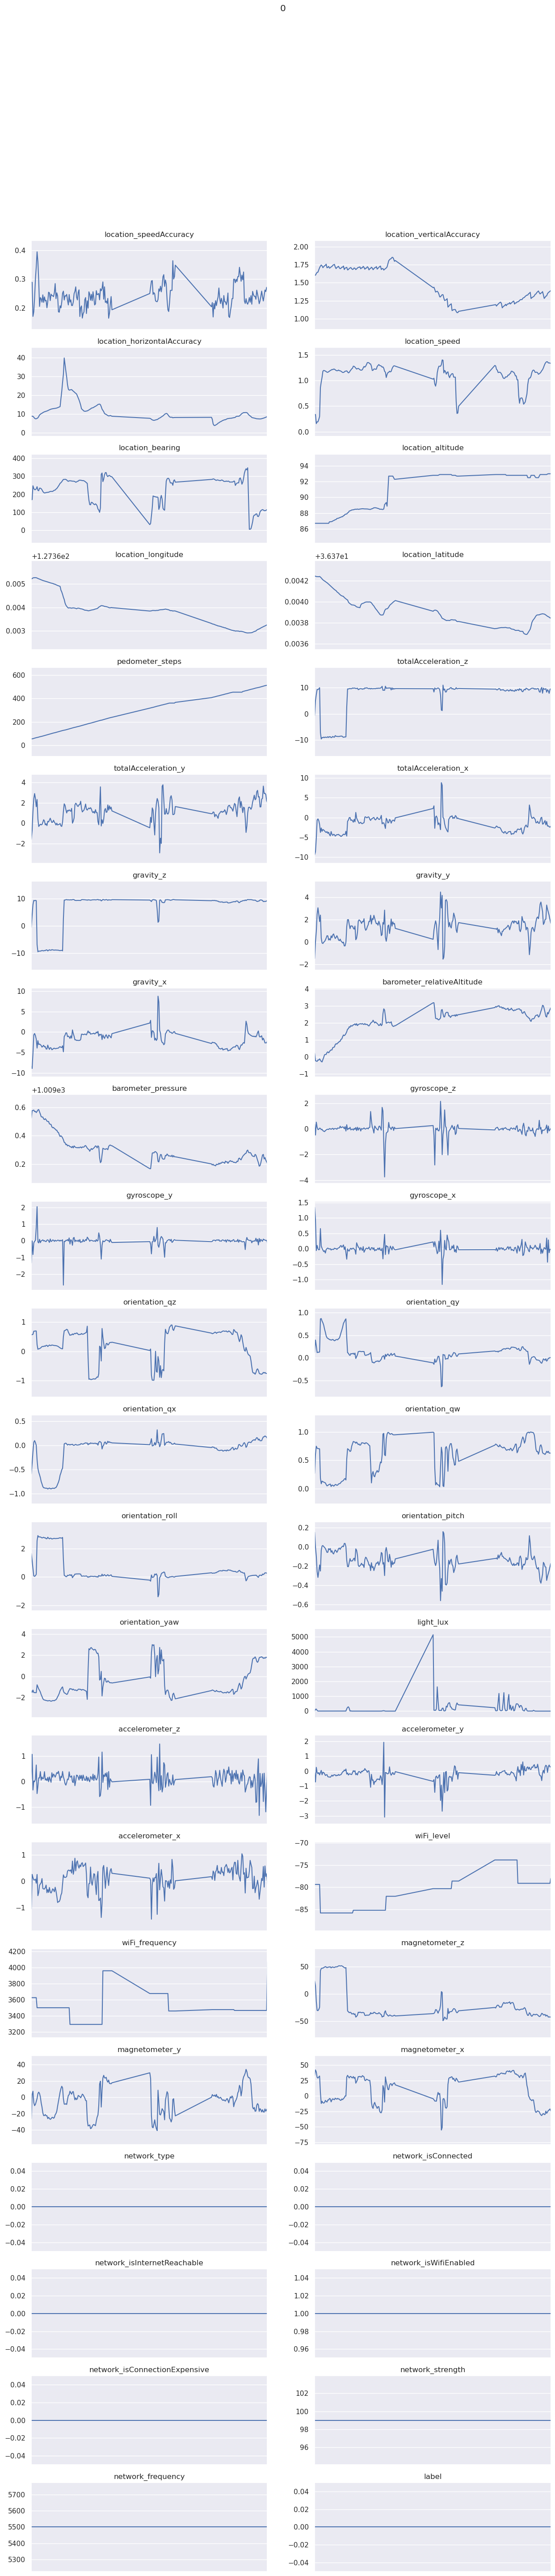

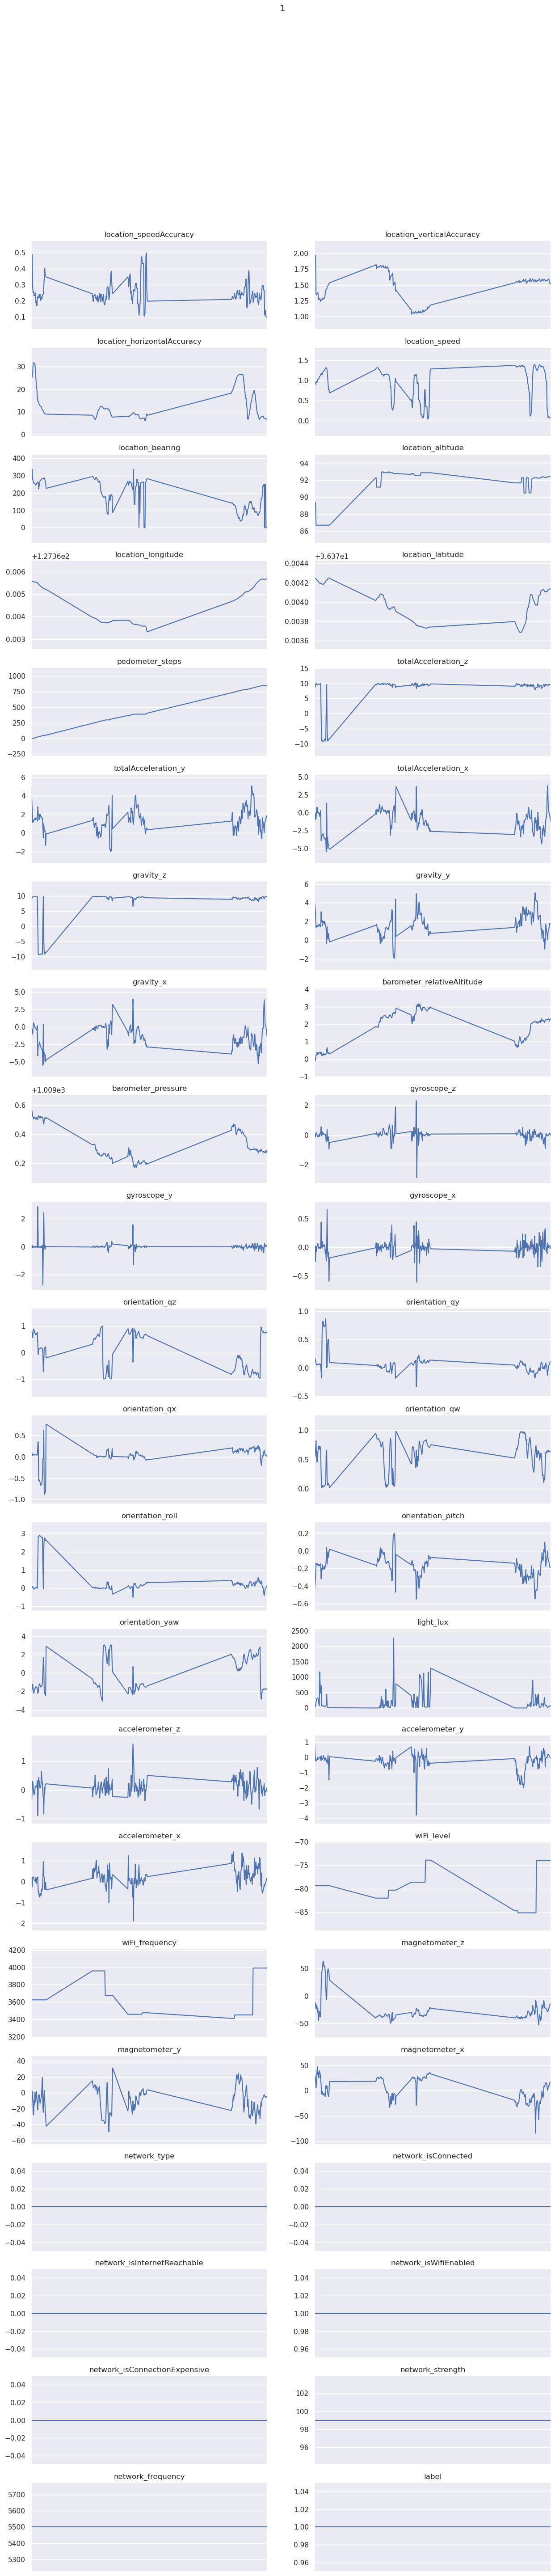

In [313]:
import matplotlib.pyplot as plt
import numpy as np

def plot_state(state, data):
    num_cols = len(data.columns) - 2  # Excluding 'index' and 'state' columns
    num_rows = (num_cols + 2 - 1) // 2  # Compute number of rows for subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 3), sharex=True)
    axes = axes.flatten()  # Flatten axes to simplify iteration
    for i, col in enumerate(data.columns[2:]):  # Exclude 'index' and 'state' columns
        plot_axis(axes[i], data['Time'], data[col], col)
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# Assuming 'data' contains your dataset and 'states' contains unique states
for state in states:
    data_for_plot = data[data['label'] == state][:Fs*10]
    plot_state(state, data_for_plot)


In [314]:
df = data.drop(['Time'], axis = 1).copy()
df['label'].value_counts()

label
0    312
1    248
Name: count, dtype: int64

/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


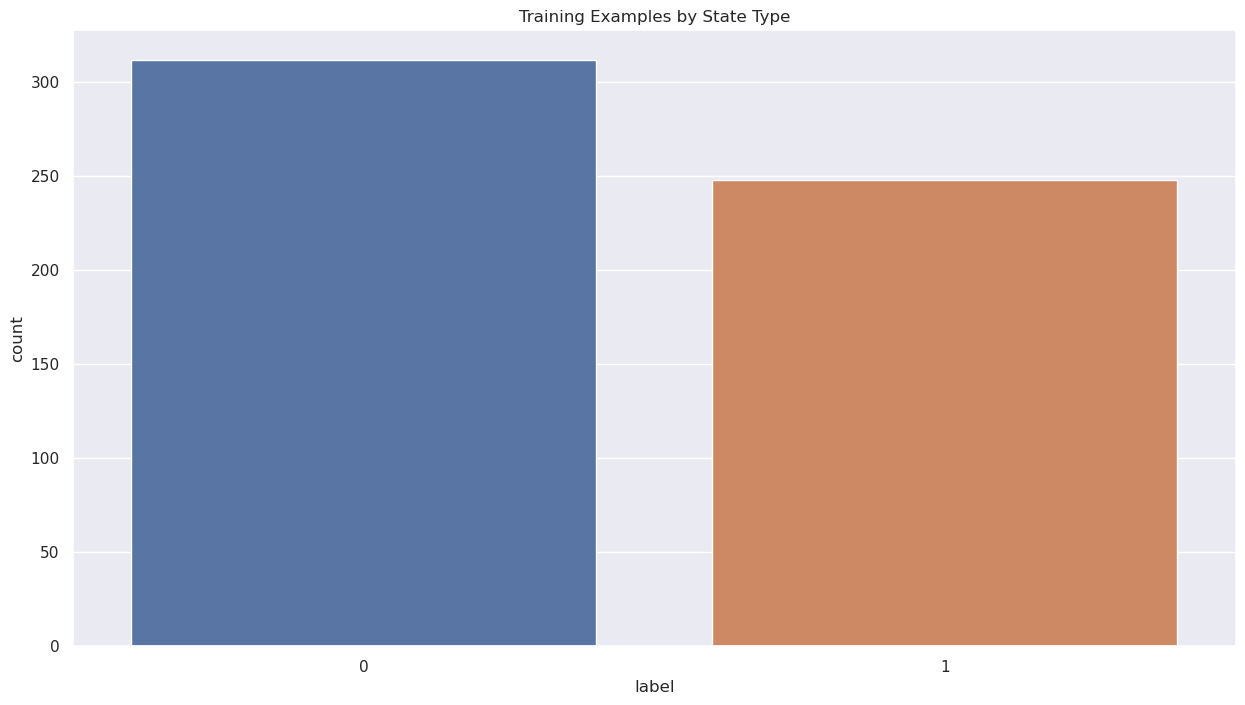

In [315]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'label', data = df)
plt.title('Training Examples by State Type')
plt.show()

In [316]:
# Filter data for 'Outdoor' and 'Indoor' states
Outdoor = df[df['label'] == 0].copy()
Indoor = df[df['label'] == 1].copy()

# Calculate the minimum count between 'Outdoor' and 'Indoor' states
min_count = min(len(Outdoor), len(Indoor))

# Cap the number of samples to the smallest count
Outdoor = Outdoor.iloc[:min_count].copy()
Indoor = Indoor.iloc[:min_count].copy()


In [317]:
try:
    balanced_data = pd.DataFrame()
    balanced_data = balanced_data.append([Outdoor, Indoor])
    balanced_data.shape
except:
    # Concatenate the DataFrames
    balanced_data = pd.concat([Outdoor, Indoor])

# Check the shape of the resulting DataFrame
print(balanced_data.shape)

(496, 45)


In [318]:
from sklearn.preprocessing import StandardScaler

# Assuming 'balanced_data' contains your dataset with features and labels

# Extract features and labels
X = balanced_data.drop(columns=['label'])  # Extract all columns except the label column
y = balanced_data['label']  # Extract the label column

# Calculate the minimum count for each label
min_count = balanced_data['label'].value_counts().min()

# Balance the dataset by capping the number of samples for each label to the smallest count
balanced_data = balanced_data.groupby('label').head(min_count)

# Separate features and labels again
X = balanced_data.drop(columns=['label'])  # Extract all columns except the label column
y = balanced_data['label']  # Extract the label column

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with scaled features and labels
scaled_X = pd.DataFrame(data=X_scaled, columns=X.columns)
scaled_X['label'] = y.values

scaled_X


,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,pedometer_steps,...,magnetometer_y,magnetometer_x,network_type,network_isConnected,network_isInternetReachable,network_isWifiEnabled,network_isConnectionExpensive,network_strength,network_frequency,label
0,0.201852,0.816226,0.578914,-0.419346,-1.612005,-0.240278,-1.163792,1.019066,1.765515,-1.447823,...,-1.227758,1.268828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.201852,0.816226,0.578914,-0.419346,-1.612005,-0.240278,-1.163792,1.019066,1.765515,-1.438441,...,0.585689,1.670331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.201852,-1.049433,0.682294,-0.433552,-2.047585,0.604134,-1.163792,1.054698,1.741956,-1.438441,...,0.835318,1.524880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.201852,-0.797250,0.756989,-0.505903,-1.962893,0.437857,-1.163792,1.062629,1.740143,-1.427182,...,-0.012914,1.147504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.201852,-0.022001,0.770616,-0.601297,-1.960349,0.365964,-1.163792,1.065868,1.739841,-1.419677,...,-0.240267,1.097566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,0.201852,-1.070307,0.585972,-0.264404,0.442053,0.322571,3.988858,1.401859,1.166867,1.620048,...,1.235270,1.034912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
492,0.201852,-0.714897,0.658709,-0.309995,0.428570,0.369669,3.993106,1.387674,1.168377,1.627553,...,1.192466,0.841591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
493,0.201852,-0.775026,0.708328,-0.382180,0.372622,0.430044,3.993531,1.372259,1.144214,1.635059,...,-0.113792,0.708309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
494,0.201852,-0.323415,0.753750,-0.463120,0.290583,0.413122,3.997780,1.358185,1.108270,1.635059,...,-0.880383,0.669409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [319]:
# Displaying the balanced data
print('Label Count:',balanced_data['label'].value_counts())

Label Count: label
0    248
1    248
Name: count, dtype: int64


/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bilz/anaconda3/envs/kt/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


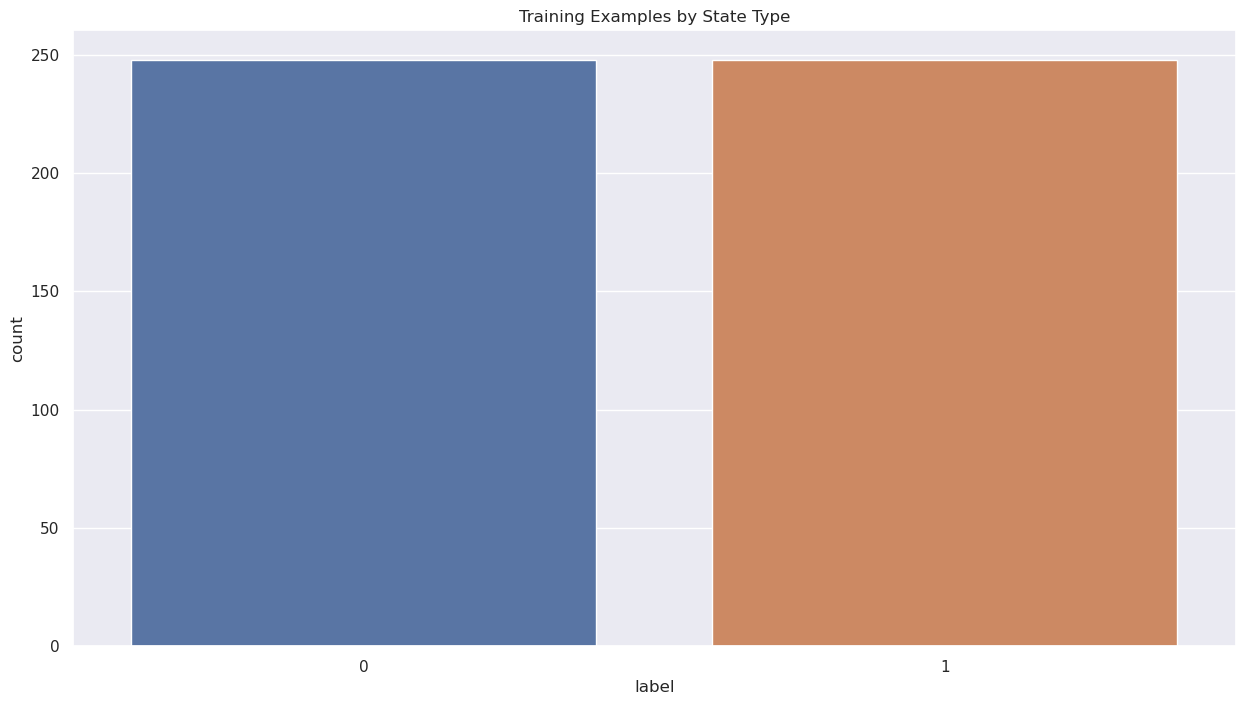

In [320]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'label', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

In [321]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['label'])
balanced_data.head()

,location_bearingAccuracy,location_speedAccuracy,location_verticalAccuracy,location_horizontalAccuracy,location_speed,location_bearing,location_altitude,location_longitude,location_latitude,pedometer_steps,...,magnetometer_y,magnetometer_x,network_type,network_isConnected,network_isInternetReachable,network_isWifiEnabled,network_isConnectionExpensive,network_strength,network_frequency,label
33,45.0,0.288948,1.604116,8.7520,0.335221,170.087662,86.700005,127.365222,36.374243,53.0,...,-26.378823,32.950588,0.0,0.0,0.0,1.0,0.0,99.0,5500.0,0
34,45.0,0.288948,1.604116,8.7520,0.335221,170.087662,86.700005,127.365222,36.374243,55.5,...,3.377647,42.201175,0.0,0.0,0.0,1.0,0.0,99.0,5500.0,0
35,45.0,0.170317,1.626936,8.6660,0.157028,246.866882,86.700005,127.365254,36.374239,55.5,...,7.473750,38.849999,0.0,0.0,0.0,1.0,0.0,99.0,5500.0,0
36,45.0,0.186353,1.643424,8.2280,0.191674,231.747879,86.700005,127.365261,36.374239,58.5,...,-6.444706,30.155293,0.0,0.0,0.0,1.0,0.0,99.0,5500.0,0
37,45.0,0.235648,1.646432,7.6505,0.192715,225.210976,86.700005,127.365264,36.374239,60.5,...,-10.175294,29.004705,0.0,0.0,0.0,1.0,0.0,99.0,5500.0,0


In [322]:
import numpy as np
import pandas as pd

# Define the get_frames function
def get_frames(df, frame_size, hop_size, feature_columns, label_column):
    N_FEATURES = len(feature_columns)

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        frame = []
        for col in feature_columns:
            frame.append(df[col].values[i: i + frame_size])
        
        # Retrieve the most common label in this segment
        label = df[label_column][i + frame_size - 1]  # Assuming label is at the end of the frame
        frames.append(frame)
        labels.append(label)

    # Convert lists to numpy arrays
    frames = np.asarray(frames)
    labels = np.asarray(labels)

    return frames, labels

# Assuming you have already defined scaled_X DataFrame and get_frames function

# Replace infinite values with NaN
scaled_X = scaled_X.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
scaled_X = scaled_X.dropna()

# Reset index after dropping rows
scaled_X = scaled_X.reset_index()

# Set parameters
#window_size = 100  # Adjust window size as needed
Fs = window_size
frame_size = window_size
hop_size = int(window_size / 3)

# Get feature columns dynamically
feature_columns = scaled_X.columns[scaled_X.columns != 'label'].tolist()

# Call the get_frames function
X, y = get_frames(scaled_X, frame_size, hop_size, feature_columns, 'label')

# Output the shapes of X and y
X.shape, y.shape


((12, 45, 100), (12,))

In [323]:
# Call the get_frames function
X, y = get_frames(scaled_X, frame_size, hop_size, feature_columns, 'label')

# Transpose X array to have shape (428, 100, 44)
X = X.transpose(0, 2, 1)

# Output the shapes of X and y
X.shape, y.shape


((12, 100, 45), (12,))

In [324]:
scaled_X.shape

(496, 46)

In [325]:
# Function to split the data with cross-validation
def getEvalData(X, y, testSize=0.2):
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=1, stratify=y)
    return X_train, X_test, y_train, y_test

In [326]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
# Get Eval Data
X_zero, X_Eval, y_zero, y_Eval = getEvalData(X,y)
X_zero.shape, X_Eval.shape, y_zero.shape, y_Eval.shape
X_Eval_C = X_Eval.reshape(X_Eval.shape[0], X_Eval.shape[1], X_Eval.shape[2], 1)
y_Eval_C = y_Eval
print(X_Eval_C.shape) 
print(y_Eval_C.shape)

Shape of X: (12, 100, 45)
Shape of y: (12,)
(3, 100, 45, 1)
(3,)


In [327]:
from keras.layers import Input


n_timesteps = X_zero.shape[1]
n_features = X_zero.shape[2]
n_outputs = outputs_class
input_shape=(n_timesteps,n_features)
inputs = Input(shape=input_shape)

print("input_shape = ",input_shape)
print("n_outputs = ",n_outputs)

input_shape =  (100, 45)
n_outputs =  2


### Load Trained Model

In [328]:
from tensorflow.keras.models import load_model

# Load the pretrained models
pretrained_modelA = load_model(modelA)
pretrained_modelB = load_model(modelB)
pretrained_modelC = load_model(modelC)
pretrained_modelD = load_model(modelD)

In [329]:
def eval_model(pretrained_model):
    # Calculate the total number of parameters
    total_params = pretrained_model.count_params()

    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes

    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)


    # Evaluate the pretrained model on the validation dataset
    eval_pred = pretrained_model.predict(X_Eval)
    eval_pred_labels = np.argmax(eval_pred, axis=1)

    if len(y_Eval.shape) > 1 and y_Eval.shape[1] > 1:
        eval_true_labels = np.argmax(y_Eval, axis=1)
    else:
        eval_true_labels = y_Eval

    eval_acc = accuracy_score(eval_true_labels, eval_pred_labels)
    eval_f1 = f1_score(eval_true_labels, eval_pred_labels, average='weighted')

    # Calculate the single prediction time
    start_time = time.time()
    pretrained_model.predict(X_Eval[:1])
    end_time = time.time()
    single_prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Calculate the total prediction time
    X_Eval_Size = len(X_Eval)
    start_time = time.time()
    pretrained_model.predict(X_Eval)
    end_time = time.time()
    total_prediction_time = (end_time - start_time) 

    if (EVALSEEN):
        print("Results on Seen Data : ", datasetNameSeen)
    else:
        print("Results on Unseen Data : ", datasetNameUnseen)
    print(f"Accuracy: {eval_acc}")
    print(f"F1-score: {eval_f1}")
    # print(f"Single Prediction Time (msec): {single_prediction_time:.6f} msec")
    # print(f"Total Prediction Time (msec): {total_prediction_time:.6f} sec")
    # print(f"Total Number of Validation Data : {X_Eval_Size:d} samples")
    # print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
    # print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
    # print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
    # print(f"Median Model Parameters (K): {total_params_kb:.2f}")

    return eval_acc

In [330]:

print("Evaluation of Model A : ")
eval_acc_modelA = eval_model(pretrained_modelA)
print("Evaluation of Model B : ")
eval_acc_modelB = eval_model(pretrained_modelB)
print("Evaluation of Model C : ")
eval_acc_modelC = eval_model(pretrained_modelC)
print("Evaluation of Model D : ")
eval_acc_modelC = eval_model(pretrained_modelD)

Evaluation of Model A : 
1/1 [==============================] - 0s 83ms/step
Results on Unseen Data :  Omer_Dataset.csv
Accuracy: 0.3333333333333333
F1-score: 0.16666666666666666
Evaluation of Model B : 
1/1 [==============================] - 0s 15ms/step
Results on Unseen Data :  Omer_Dataset.csv
Accuracy: 0.3333333333333333
F1-score: 0.16666666666666666
Evaluation of Model C : 
1/1 [==============================] - 0s 14ms/step
Results on Unseen Data :  Omer_Dataset.csv
Accuracy: 0.6666666666666666
F1-score: 0.5333333333333333
Evaluation of Model D : 
1/1 [==============================] - 0s 81ms/step
Results on Unseen Data :  Omer_Dataset.csv
Accuracy: 0.3333333333333333
F1-score: 0.16666666666666666
